In [11]:
!nvidia-smi

Mon Nov  9 02:53:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   53C    P0   124W / 300W |   6474MiB / 32480MiB |     83%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [12]:
import pylab
import imageio
import cv2
import os
from glob import glob
from tqdm import tqdm,tnrange
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import tensorflow as tf
import time

In [13]:
import io
import scipy.misc
import six
import time

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont




import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
%matplotlib inline

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    except RuntimeError as e:
        # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

In [15]:
def get_keypoint_tuples(eval_config):
    """Return a tuple list of keypoint edges from the eval config.

    Args:
    eval_config: an eval config containing the keypoint edges

    Returns:
    a list of edge tuples, each in the format (start, end)
    """
    tuple_list = []
    kp_list = eval_config.keypoint_edge
    for edge in kp_list:
        tuple_list.append((edge.start, edge.end))
    return tuple_list

In [16]:
!pwd

/home/workspace/user-workspace/object_tracking/madfalcon/tf_models/research


In [17]:
cam_number = 0

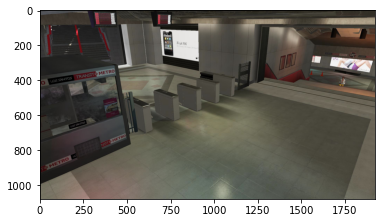

In [18]:
# test_dir = f'/home/workspace/user-workspace/object_tracking/madfalcon/data_test/cam_{cam_number}/'
test_dir = f'/home/workspace/user-workspace/object_tracking/madfalcon/data/cam_{cam_number}/'
image = cv2.imread(test_dir + '0.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.reshape((1,) + image.shape) #차원추가
image = tf.cast(image, tf.float32) / 255.0
plt.imshow(image[0])

In [29]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
cam_number = 0
PATH_TO_CFG = f'/home/workspace/user-workspace/object_tracking/madfalcon/efficientdet_d1_coco17_tpu-32/pipeline_cam_{cam_number}.config'
PATH_TO_CKPT = f'/home/workspace/user-workspace/object_tracking/madfalcon/result_{cam_number}/'

print('Loading model... ', end='')
start_time = time.time()

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
# print(f"model_config : {model_config}")
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
last_chkpoint_path = tf.train.latest_checkpoint(PATH_TO_CKPT, latest_filename=None)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
# ckpt.restore(last_chkpoint_path).expect_partial()
ckpt.restore('/home/workspace/user-workspace/object_tracking/madfalcon/result_0/ckpt-5').expect_partial()

print(f'last chkpoint : {last_chkpoint_path}')
print('checkpoint restore complete')

def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
#     print("test")
#     print(len(image), shapes)
    
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
#     print(detections)
    
    return detections

end_time = time.time()
detections_result = detect_fn(image)
# print(result)
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model... last chkpoint : /home/workspace/user-workspace/object_tracking/madfalcon/result_0/ckpt-11
checkpoint restore complete
Done! Took 9.008964538574219 seconds


In [31]:
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

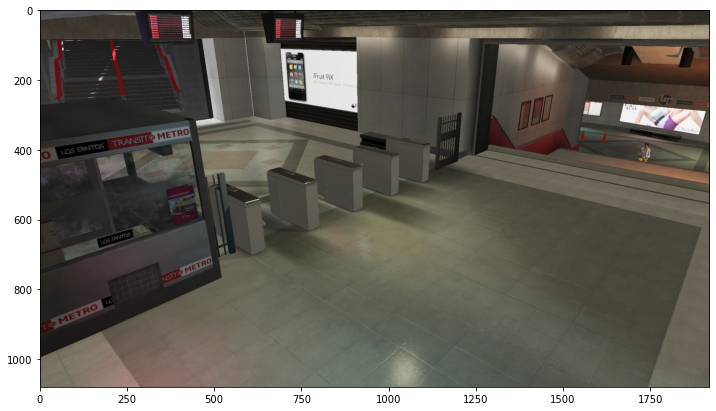

In [32]:
"""
수정사항
    tf_models/research/object_detection/utils/visualization_utils.py : 163, 코드 추가
        np.copyto(image, np.array(image_pil)) - > np.copyto(image, image_pil.numpy())
"""

label_id_offset = 1
image_np_with_detections = image[0]

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in detections_result:
    keypoints = detections['detection_keypoints'][0].numpy()
    keypoint_scores = detections['detection_keypoint_scores'][0].numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections_result['detection_boxes'][0].numpy(),
      (detections_result['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections_result['detection_scores'][0].numpy(),
#       target_np,
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.3,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=get_keypoint_tuples(configs['eval_config']))

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

In [33]:
detections_result['detection_scores']

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[0.01063415, 0.01061383, 0.010613  , 0.0106029 , 0.01059304,
        0.01058456, 0.01056695, 0.01055389, 0.01054702, 0.01054445,
        0.01053623, 0.01053207, 0.01052988, 0.01052504, 0.01052359,
        0.01051725, 0.01050985, 0.01050853, 0.0105079 , 0.01050045,
        0.01048575, 0.01047294, 0.01047233, 0.01047202, 0.01047027,
        0.01046741, 0.0104655 , 0.01045954, 0.01045862, 0.01045468,
        0.01045341, 0.01045297, 0.01045237, 0.01044135, 0.01044089,
        0.01043028, 0.0104255 , 0.01042447, 0.01042346, 0.01041398,
        0.01041005, 0.0104084 , 0.01040474, 0.01040455, 0.01039951,
        0.01039843, 0.01039428, 0.01039259, 0.01038559, 0.01038437,
        0.01038329, 0.01037887, 0.01037651, 0.01037618, 0.01037584,
        0.01037505, 0.01037489, 0.01037485, 0.01037484, 0.01037366,
        0.01036967, 0.01036843, 0.01036797, 0.01036724, 0.01036354,
        0.01036248, 0.01035773, 0.01035551, 0.01035089, 0.01034875

In [14]:
# height = image.shape[1]
# width = image.shape[2]
# print(height,width)

# # plt.imshow(image[0])
# # plt.show()
# xmin, xmax = int(target_box_np[0][0] * height), int(target_box_np[0][2] * height)
# print(xmin,xmax)
# ymin, ymax = int(target_box_np[0][1] * width), int(target_box_np[0][3] * width)
# print(ymin,ymax)
# cp_image = image[0].numpy().copy()
# # cv2.rectangle(cp_image,(xmin,ymin),(xmax,ymax),(255,255,0),3)
# cv2.rectangle(cp_image,(ymin,xmin),(ymax,xmax),(255,255,0),10)
# plt.imshow(cp_image)
# plt.show()

In [11]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path (this can be local or on colossus)

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    print(f'path : {path}')
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

cam_number = 0
PATH_TO_CFG = f'/home/workspace/user-workspace/object_tracking/madfalcon/efficientdet_d1_coco17_tpu-32/pipeline_cam_{cam_number}.config'
PATH_TO_CKPT = f'/home/workspace/user-workspace/object_tracking/madfalcon/result_{cam_number}/'

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
# Load the COCO Label Map
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

In [12]:
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load(f'/home/workspace/user-workspace/object_tracking/madfalcon/result_{cam_number}_export/saved_model')
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 32.00266122817993s


path : /home/workspace/user-workspace/object_tracking/madfalcon/data/cam_0/3.jpg
Elapsed time: 93.93882846832275 second per image


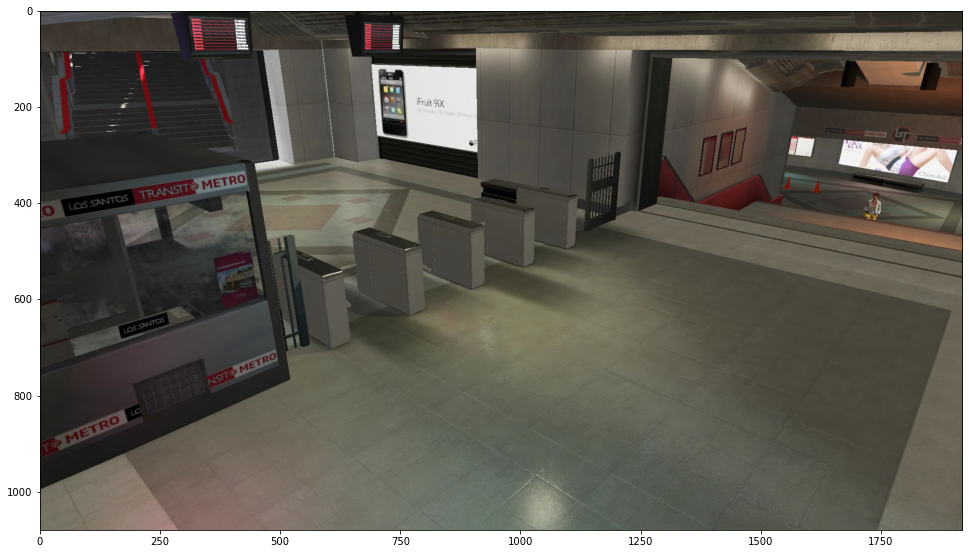

In [13]:
import time

cam_number = 0
image_dir = f'/home/workspace/user-workspace/object_tracking/madfalcon/data/cam_{cam_number}/'

row = 2
col = 2
elapsed = []
for i in range(3,4):
    image_path = os.path.join(image_dir, str(i)+'.jpg')
    image_np = load_image_into_numpy_array(image_path)
    input_tensor = np.expand_dims(image_np, 0)
    start_time = time.time()
    detections = detect_fn(input_tensor)
    end_time = time.time()
    elapsed.append(end_time - start_time)

    plt.rcParams['figure.figsize'] = [42, 21]
    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.int32),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.20,
        agnostic_mode=False)
    val = (i+1)%row
    if val == 0:
        val = 1
    plt.subplot(row, col, val)
    plt.imshow(image_np_with_detections)

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

In [24]:
print(detections['detection_classes'])

tf.Tensor(
[[30. 26. 31. 25.  8. 28. 30. 24. 29.  3. 11.  8. 27. 31. 28. 26. 25. 26.
   3. 27. 29. 25. 25. 28. 24.  5. 20. 28.  7. 10. 16. 24. 27. 31.  8.  4.
   6. 11.  1. 10.  7. 30.  6. 31.  8. 28.  5. 15.  6. 12. 26. 29.  4. 20.
   5.  8. 19. 22. 29.  1. 16. 28.  4. 27. 31. 24. 30.  6.  3. 30. 10.  6.
  22. 26. 30. 26.  5.  6. 10.  2. 31.  8. 28. 29. 16. 30. 29.  5. 25.  8.
  27. 27. 13. 16. 15. 25. 11. 12. 10. 28.]], shape=(1, 100), dtype=float32)


In [14]:
print(detections['detection_scores'])

tf.Tensor(
[[0.08650368 0.07909323 0.07071495 0.07041001 0.06721696 0.06203736
  0.06102803 0.06076705 0.06038175 0.05745703 0.05742038 0.05440847
  0.05298859 0.05130722 0.04908183 0.04897462 0.04808257 0.04741795
  0.04709063 0.04625953 0.04549858 0.04495113 0.04462757 0.04396086
  0.0439242  0.04379256 0.0436319  0.04305748 0.04293028 0.04279886
  0.04260784 0.04258997 0.04205706 0.04198795 0.04177695 0.0414213
  0.04100285 0.0404553  0.03924857 0.0386272  0.03794252 0.03735282
  0.03707717 0.03702701 0.03691571 0.03689099 0.03607194 0.03578799
  0.03577871 0.0357241  0.03557028 0.03555172 0.03539468 0.03525188
  0.035232   0.03469979 0.03437243 0.03425265 0.03410683 0.03407154
  0.0338519  0.03383555 0.03381587 0.03379745 0.033342   0.03317145
  0.03311829 0.03294715 0.03294621 0.03284769 0.0328034  0.03278215
  0.03230315 0.03216892 0.03205253 0.03192527 0.03187092 0.03181449
  0.03164124 0.03138328 0.03136246 0.03134953 0.03123221 0.03120344
  0.03115751 0.03103275 0.03089135 0.0

1080 1920
path : /home/workspace/user-workspace/object_tracking/madfalcon/data/cam_0/3.jpg
370 452
1709 1756


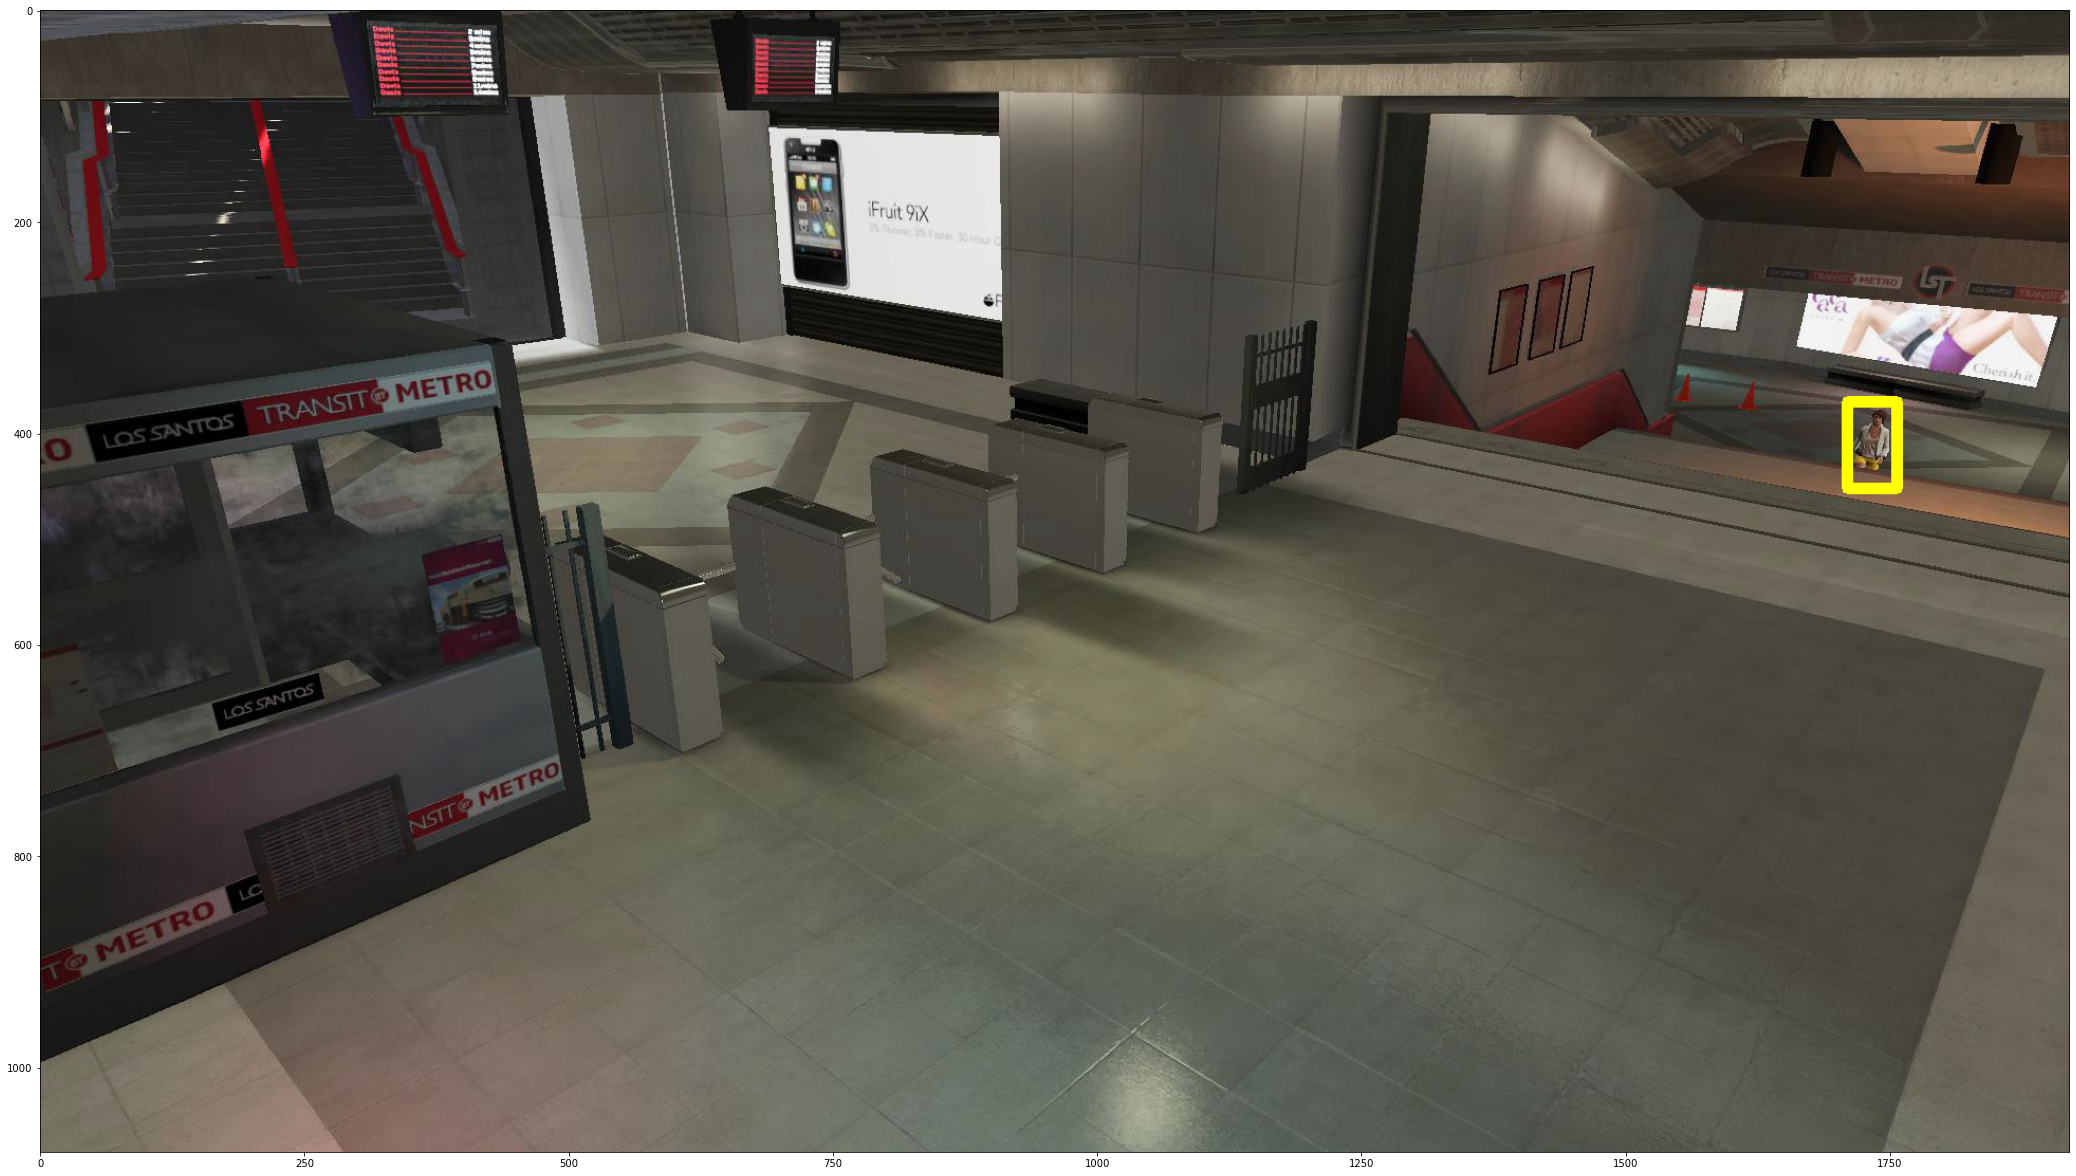

In [22]:
height = image.shape[1]
width = image.shape[2]
print(height,width)
target_box_np = detections['detection_boxes'][0].numpy()
image_path = os.path.join(image_dir, str(i)+'.jpg')
image_np = load_image_into_numpy_array(image_path)
# plt.imshow(image[0])
# plt.show()
target_num = 1

xmin, xmax = int(target_box_np[target_num][0] * height), int(target_box_np[target_num][2] * height)
print(xmin,xmax)
ymin, ymax = int(target_box_np[target_num][1] * width), int(target_box_np[target_num][3] * width)
print(ymin,ymax)
# cp_image = image_np[0].numpy().copy()
# cv2.rectangle(cp_image,(xmin,ymin),(xmax,ymax),(255,255,0),3)
cv2.rectangle(image_np,(ymin,xmin),(ymax,xmax),(255,255,0),10)
plt.imshow(image_np)
plt.show()

In [ ]:
!nvidia-smi

import pylab
import imageio
import cv2
import os
from glob import glob
from tqdm import tqdm,tnrange
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import tensorflow as tf
import time

import io
import scipy.misc
import six
import time

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont




import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
%matplotlib inline

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    except RuntimeError as e:
        # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

def get_keypoint_tuples(eval_config):
    """Return a tuple list of keypoint edges from the eval config.

    Args:
    eval_config: an eval config containing the keypoint edges

    Returns:
    a list of edge tuples, each in the format (start, end)
    """
    tuple_list = []
    kp_list = eval_config.keypoint_edge
    for edge in kp_list:
        tuple_list.append((edge.start, edge.end))
    return tuple_list

!pwd

cam_number = 0

# test_dir = f'/home/workspace/user-workspace/object_tracking/madfalcon/data_test/cam_{cam_number}/'
test_dir = f'/home/workspace/user-workspace/object_tracking/madfalcon/data/cam_{cam_number}/'
image = cv2.imread(test_dir + '0.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.reshape((1,) + image.shape) #차원추가
image = tf.cast(image, tf.float32) / 255.0
plt.imshow(image[0])

import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
cam_number = 0
PATH_TO_CFG = f'/home/workspace/user-workspace/object_tracking/madfalcon/efficientdet_d1_coco17_tpu-32/pipeline_cam_{cam_number}.config'
PATH_TO_CKPT = f'/home/workspace/user-workspace/object_tracking/madfalcon/result_{cam_number}/'

print('Loading model... ', end='')
start_time = time.time()

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
# print(f"model_config : {model_config}")
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
last_chkpoint_path = tf.train.latest_checkpoint(PATH_TO_CKPT, latest_filename=None)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
# ckpt.restore(last_chkpoint_path).expect_partial()
ckpt.restore('/home/workspace/user-workspace/object_tracking/madfalcon/result_0/ckpt-5').expect_partial()

print(f'last chkpoint : {last_chkpoint_path}')
print('checkpoint restore complete')

def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
#     print("test")
#     print(len(image), shapes)
    
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
#     print(detections)
    
    return detections

end_time = time.time()
detections_result = detect_fn(image)
# print(result)
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

"""
수정사항
    tf_models/research/object_detection/utils/visualization_utils.py : 163, 코드 추가
        np.copyto(image, np.array(image_pil)) - > np.copyto(image, image_pil.numpy())
"""

label_id_offset = 1
image_np_with_detections = image[0]

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in detections_result:
    keypoints = detections['detection_keypoints'][0].numpy()
    keypoint_scores = detections['detection_keypoint_scores'][0].numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections_result['detection_boxes'][0].numpy(),
      (detections_result['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections_result['detection_scores'][0].numpy(),
#       target_np,
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.3,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=get_keypoint_tuples(configs['eval_config']))

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

detections_result['detection_scores']

# height = image.shape[1]
# width = image.shape[2]
# print(height,width)

# # plt.imshow(image[0])
# # plt.show()
# xmin, xmax = int(target_box_np[0][0] * height), int(target_box_np[0][2] * height)
# print(xmin,xmax)
# ymin, ymax = int(target_box_np[0][1] * width), int(target_box_np[0][3] * width)
# print(ymin,ymax)
# cp_image = image[0].numpy().copy()
# # cv2.rectangle(cp_image,(xmin,ymin),(xmax,ymax),(255,255,0),3)
# cv2.rectangle(cp_image,(ymin,xmin),(ymax,xmax),(255,255,0),10)
# plt.imshow(cp_image)
# plt.show()









def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path (this can be local or on colossus)

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    print(f'path : {path}')
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

cam_number = 0
PATH_TO_CFG = f'/home/workspace/user-workspace/object_tracking/madfalcon/efficientdet_d1_coco17_tpu-32/pipeline_cam_{cam_number}.config'
PATH_TO_CKPT = f'/home/workspace/user-workspace/object_tracking/madfalcon/result_{cam_number}/'

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
# Load the COCO Label Map
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)





start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load(f'/home/workspace/user-workspace/object_tracking/madfalcon/result_{cam_number}_export/saved_model')
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

import time

cam_number = 0
image_dir = f'/home/workspace/user-workspace/object_tracking/madfalcon/data/cam_{cam_number}/'

row = 2
col = 2
elapsed = []
for i in range(3,4):
    image_path = os.path.join(image_dir, str(i)+'.jpg')
    image_np = load_image_into_numpy_array(image_path)
    input_tensor = np.expand_dims(image_np, 0)
    start_time = time.time()
    detections = detect_fn(input_tensor)
    end_time = time.time()
    elapsed.append(end_time - start_time)

    plt.rcParams['figure.figsize'] = [42, 21]
    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.int32),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.20,
        agnostic_mode=False)
    val = (i+1)%row
    if val == 0:
        val = 1
    plt.subplot(row, col, val)
    plt.imshow(image_np_with_detections)

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

print(detections['detection_classes'])

print(detections['detection_scores'])

height = image.shape[1]
width = image.shape[2]
print(height,width)
target_box_np = detections['detection_boxes'][0].numpy()
image_path = os.path.join(image_dir, str(i)+'.jpg')
image_np = load_image_into_numpy_array(image_path)
# plt.imshow(image[0])
# plt.show()
target_num = 1

xmin, xmax = int(target_box_np[target_num][0] * height), int(target_box_np[target_num][2] * height)
print(xmin,xmax)
ymin, ymax = int(target_box_np[target_num][1] * width), int(target_box_np[target_num][3] * width)
print(ymin,ymax)
# cp_image = image_np[0].numpy().copy()
# cv2.rectangle(cp_image,(xmin,ymin),(xmax,ymax),(255,255,0),3)
cv2.rectangle(image_np,(ymin,xmin),(ymax,xmax),(255,255,0),10)
plt.imshow(image_np)
plt.show()

